In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
pd.options.mode.chained_assignment = None

from bound_funcs import *
from simulations import *

## Iterate on a realistic DGP

In [121]:
D = np.random.binomial(1, .8, size=1000)
A =  np.random.binomial(1, .6, size=1000)
Y = np.random.binomial(1, .8, size=1000)

v11 = ((D==1) & (A==1) & (Y==1)).mean()
v01 = ((D==1) & (A==0) & (Y==1)).mean()
w11 = ((D==1) & (A==1) & (Y==0)).mean()
w01 = ((D==1) & (A==0) & (Y==0)).mean()

rho00 = ((A==0) & (D==0)).mean()
rho01 = ((A==0) & (D==1)).mean()
rho10 = ((A==1) & (D==0)).mean()
rho11 = ((D==1) & (A==1)).mean()

v10 = ((A==1) & (D==0) & (Y==1)).mean()
v00 = ((A==0) & (D==0) & (Y==1)).mean()
w10 = ((A==1) & (D==0) & (Y==0)).mean()
w00 = ((A==0) & (D==0) & (Y==0)).mean()

v10_up = ((A==1) & (D==0)).mean()
w10_down = 0

In [13]:
regret = ((A==0) & (Y==0)).mean() / (A==0).mean() - ((D==0) & (Y==0)).mean() / (D==0).mean()




NameError: name 'p10' is not defined

In [7]:
nz = 10
dgp = {
    'N': 10000,
    'nz': nz,
    'beta': 2.5*(1/nz) ,
    'wa': np.array([-1.95, .01, 2, .01]), 
    'wd': np.array([-1.1, 1.7, .01, 1.5, .2, .2]),
    'w_mu1': np.array([1.3, .8, .02, .9, .3, .6]),
    'w_mu0': np.array([1.5, .05, 1.8, .05, .2, .5])
}
data = sigmoid_dgp(dgp)
u = np.array([[0,0], [0, 0]])

In [9]:
one_step_bounds(data, dgp, u, metric='FNR', id_strategy='Manski')

(0.2360884242622237,
 0.749942116230609,
 {'v10_down': 0,
  'v10_up': 0.1071,
  'v00_down': 0,
  'v00_up': 0.3793,
  'w10_down': 0,
  'w10_up': 0.1071,
  'w00_down': 0,
  'w00_up': 0.3793})

In [10]:
one_step_bounds(data, dgp, u, metric='TPR', id_strategy='Manski')

(-0.749942116230609,
 -0.2360884242622237,
 {'v10_down': 0,
  'v10_up': 0.1071,
  'v00_down': 0,
  'v00_up': 0.3793,
  'w10_down': 0,
  'w10_up': 0.1071,
  'w00_down': 0,
  'w00_up': 0.3793})

In [12]:
one_step_bounds(data, dgp, u, metric='FPR', id_strategy='Manski')

(-0.850673194614443,
 0.19915254237288132,
 {'v10_down': 0,
  'v10_up': 0.1071,
  'v00_down': 0,
  'v00_up': 0.3793,
  'w10_down': 0,
  'w10_up': 0.1071,
  'w00_down': 0,
  'w00_up': 0.3793})

In [13]:
one_step_bounds(data, dgp, u, metric='TNR', id_strategy='Manski')

(-0.19915254237288132,
 0.850673194614443,
 {'v10_down': 0,
  'v10_up': 0.1071,
  'v00_down': 0,
  'v00_up': 0.3793,
  'w10_down': 0,
  'w10_up': 0.1071,
  'w00_down': 0,
  'w00_up': 0.3793})

In [14]:
two_step_bounds(data, dgp, u, metric='FNR', id_strategy='Manski')

(0.0712532454400191,
 0.8668639053254438,
 {'v10_down': 0,
  'v10_up': 0.1071,
  'v00_down': 0,
  'v00_up': 0.3793,
  'w10_down': 0,
  'w10_up': 0.1071,
  'w00_down': 0,
  'w00_up': 0.3793})

In [15]:
two_step_bounds(data, dgp, u, metric='TPR', id_strategy='Manski')

(-0.8668639053254438,
 -0.07125324544001915,
 {'v10_down': 0,
  'v10_up': 0.1071,
  'v00_down': 0,
  'v00_up': 0.3793,
  'w10_down': 0,
  'w10_up': 0.1071,
  'w00_down': 0,
  'w00_up': 0.3793})

In [16]:
oracle_regret(data, u, metric='TPR')

-0.2995747970622342

In [17]:
oracle_regret(data, u, metric='FNR')

0.2995747970622342

In [3]:
nz = 10
dgp = {
    'N': 10000,
    'nz': nz,
    'beta': 2.5*(1/nz) ,
    'wa': np.array([-1.95, .01, 2, .01]), 
    'wd': np.array([-1.1, 1.7, .01, 1.5, .2, .2]),
    'w_mu1': np.array([1.3, .8, .02, .9, .3, .6]),
    'w_mu0': np.array([1.5, .05, 1.8, .05, .2, .5])
}

u = np.array([[0,-1], [-20, 0]])

metric='TNR'
id_strategies = ['IV', 'Manski']
regret_runs = run_sigmoid_dgp_simulation(dgp, u, metric, id_strategies, n_runs=10)
regret_df = regret_runs.groupby(['tag', 'ID_type']).mean().reset_index()

regret_df = regret_df.sort_values(by='tag', ascending=True)
regret_runs = regret_runs.sort_values(by='tag', ascending=True)




# Main result plot

In [18]:
# Subgroup-level plot
bound_plot(metric, regret_df, regret_runs, save=False)

NameError: name 'bound_plot' is not defined

# Policy value plot

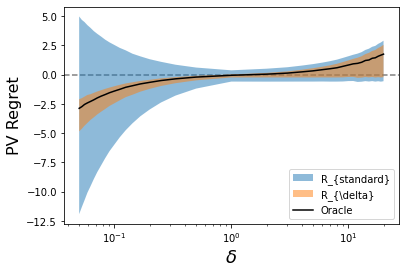

In [6]:
nz = 10
n_runs = 5

dgp = {
    'N': 15000,
    'nz': nz,
    'beta': 2.5*(1/nz) ,
    'wa': np.array([-1.6, .01, 2, .01]), 
    'wd': np.array([-1, 1.7, .01, 1.5, .2, .2]),
    'w_mu1': np.array([.12, .8, .02, .9, .3, .6]),
    'w_mu0': np.array([.33, .05, 1.8, .05, .2, .5])
}

id_strategies=['MSM']

results = pv_simulation(dgp, id_strategies, n_runs)

crdf = pd.concat(results)
crdf = crdf[crdf['tag'] == 'Population']
crdf = crdf.sort_values(by='cost_ratio')
crdf = crdf.groupby('cost_ratio').mean().reset_index()

plt.axhline(0, color='grey', zorder=1, linestyle='--')
plt.fill_between(crdf['cost_ratio'], crdf['TS_down'],crdf['TS_up'], alpha=.5, label='R_{standard}')
plt.fill_between(crdf['cost_ratio'], crdf['OS_down'],crdf['OS_up'], alpha=.5, label='R_{\delta}')
plt.plot(crdf['cost_ratio'], crdf['R'], color='k', label='Oracle')
plt.xscale('log',base=10) 
plt.legend(loc='lower right')

plt.xlabel('$\delta$', fontsize=18)
plt.ylabel('PV Regret', fontsize=16)
plt.savefig('figs/pv_regret.png', dpi=400, bbox_inches='tight')

In [43]:
crdf.columns

Index(['v11', 'v01', 'w11', 'w01', 'v10_true', 'v00_true', 'w10_true',
       'w00_true', 'TS_down', 'TS_up', 'OS_down', 'OS_up', 'ID_type', 'SR',
       'pG', 'tag', 'R', 'run', 'metric', 'v10_down', 'v10_up', 'v00_down',
       'v00_up', 'w10_down', 'w10_up', 'w00_down', 'w00_up', 'ASR', 'ASD',
       'pD', 'pA', 'pY'],
      dtype='object')

In [2]:
## Policy value plot
N=20000
n_runs = 2
id_strategies=['Manski']
metrics = ['FPR', 'FNR', 'TPR', 'TNR', 'ACCURACY', 'PPV', 'NPV']

results = DAY_bernoulli_simulation(N, id_strategies, metrics, n_runs)

crdf = pd.DataFrame(results)
delta00 = (crdf['w00_up'] - crdf['w00_down'])
delta10 = (crdf['w10_up'] - crdf['w10_down'])

v_up = crdf['v11'] + crdf['v01'] + crdf['v10_up'] + crdf['v00_up']
v_down = crdf['v11'] + crdf['v01'] + crdf['v10_down'] + crdf['v00_down']

crdf['rho_00'] = crdf['v00_true'] + crdf['w00_true']
crdf['rho_01'] = crdf['v01'] + crdf['w01']
crdf['rho_10'] = crdf['v10_true'] + crdf['w10_true']
crdf['rho_11'] = crdf['v11'] + crdf['w11']

crdf['pD'] = crdf['v11'] + crdf['v01'] + crdf['w01'] + crdf['w11']
crdf['pT'] = crdf['v10_true'] + crdf['v11'] + crdf['w10_true'] + crdf['w11']

crdf['n_pD'] = 1 - crdf['pD']
crdf['n_pT'] = 1 - crdf['pT']

crdf['pY'] = crdf['v11'] + crdf['v01'] + crdf['v10_true'] + crdf['v00_true']

crdf['PC'] = (delta00*crdf['v11'])/(v_up**2)
crdf['NC'] = (delta00*crdf['w11'])/((1-v_down)**2)

crdf['NPV_bound'] = (delta00)/crdf[['n_pD', 'n_pT']].max(axis=1)
crdf['ACCURACY'] = delta00



NameError: name 'DAY_bernoulli_simulation' is not defined

In [3]:

# Group by bound improvement metrics

def plot_metrics(crdf, metrics, bound_keys, axis_titles, n_bins=20):

    n_metrics = len(metrics)

    fig, axs = plt.subplots(1, len(metrics), figsize=(5*n_metrics, 5), sharey=False)
    
    if n_metrics == 1:
        axs = list([axs])

    for i, metric in enumerate(metrics):
    
        mdf = crdf[crdf['metric'] == metric]
        bound_var = bound_keys[i]
    
        mdf[bound_var] = (mdf[bound_var]*n_bins).round()/n_bins
        mdf = mdf.groupby([bound_var]).mean().reset_index()
        mdf = mdf.sort_values(by=bound_var, ascending=True)

        axs[i].fill_between(mdf[bound_var], mdf['TS_down'], mdf['TS_up'], alpha=.5, label='$R$')
        axs[i].fill_between(mdf[bound_var], mdf['OS_down'],mdf['OS_up'], alpha=.5, label='$R_{\delta}$')
        axs[i].plot(mdf[bound_var], mdf[f'R'], color='k', label='Oracle')
        axs[i].set_title(metric, fontsize=18)
        axs[i].axhline(color='grey', alpha=.2)

        axs[i].set_xlabel(axis_titles[i], fontsize=18)


    axs[0].set_ylabel('Regret', fontsize=18)
    axs[0].legend()
    plt.tight_layout()
    metric_string = '_'.join(metrics)
    plt.savefig(f'figs/{metric_string}_bound_plots.png', dpi=500, bbox_inches='tight')


KeyError: 'metric'

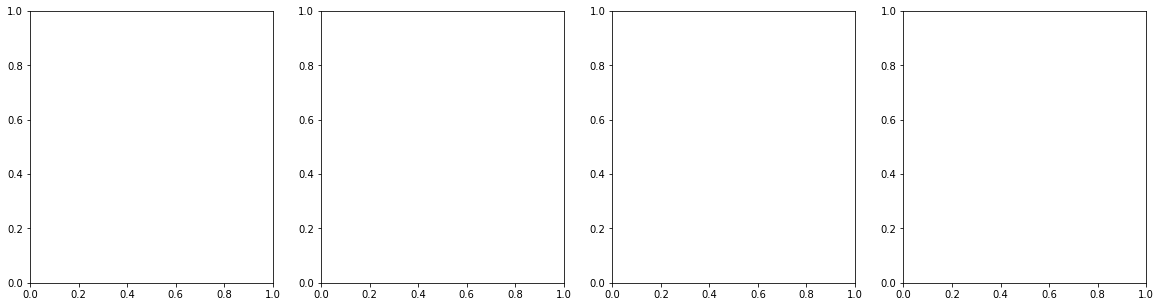

In [16]:
metrics = ['FNR', 'TPR','FPR', 'TNR']
bound_keys = ['PC', 'PC','NC', 'NC']
axis_titles = ['$\Delta_{+}$', '$\Delta_{+}$', '$\Delta_{-}$', '$\Delta_{-}$']


plot_metrics(crdf, metrics, bound_keys, axis_titles, n_bins=25)

KeyError: 'metric'

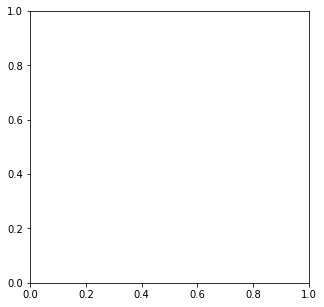

In [17]:
metrics = ['ACCURACY']
bound_keys = ['ACCURACY']
axis_titles = ['$\delta_{00}$']

plot_metrics(crdf, metrics, bound_keys, axis_titles)

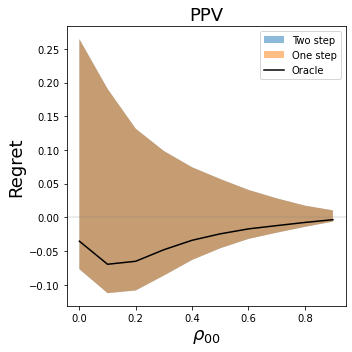

In [32]:
metrics = ['PPV']
bound_keys = ['rho_11']
axis_titles = [r'$\rho_{00}$']

plot_metrics(crdf, metrics, bound_keys, axis_titles, n_bins=10)

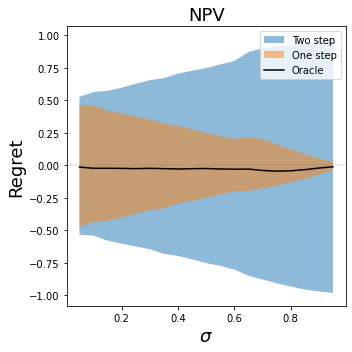

In [37]:
metrics = ['NPV']
bound_keys = ['NPV_bound']
axis_titles = [r'$\sigma$']

plot_metrics(crdf, metrics, bound_keys, axis_titles, n_bins=20)

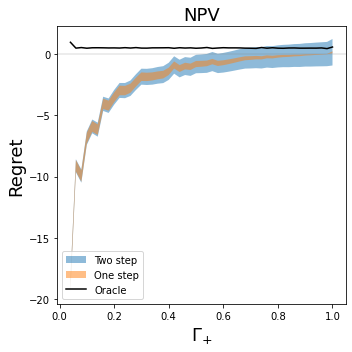

In [4]:
metrics = ['NPV']
bound_keys = ['NPV_bound']
axis_titles = ['$\Gamma_{+}$']

plot_metrics(crdf, metrics, bound_keys, axis_titles, n_bins=50)

<AxesSubplot:>

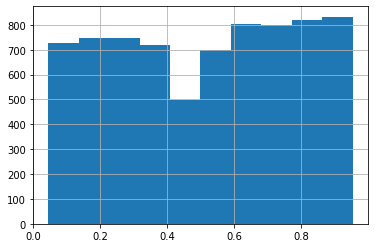

In [53]:
num = (crdf[crdf['NPV_bound'] < .3]['v01'] + crdf[crdf['NPV_bound'] < .3]['v11'])
denom = (crdf[crdf['NPV_bound'] < .3]['rho_01'] + crdf[crdf['NPV_bound'] < .3]['rho_11'])

(num/denom).hist()

In [33]:
crdf['pD'].mean(), crdf['pT'].mean()

(0.6223759440151626, 0.3000477426252612)

## Numeric subgroup example 

In [6]:
dgp = {
    'pD': .19,
    'pA': .29,
    'pY': .1,
    'N': 30000
}

D = np.random.binomial(1, dgp['pD'], size=dgp['N'])
A = np.random.binomial(1, dgp['pA'], size=dgp['N'])
Y = np.random.binomial(1, dgp['pY'], size=dgp['N'])

RMAG =  np.random.binomial(1, .8, size=dgp['N'])
DA_corr =  np.random.binomial(1, .8, size=dgp['N'])
   
    
A[(D == 0) & (DA_corr == 1)] = 0

D[(A == 1) & (D == 0) & (Y == 1) & (RMAG == 1)] = 1 
A[(A == 1) & (D == 0) & (Y == 1) & (RMAG == 1)] = 0

vstats = get_v_stats(D, A, Y)

data = { 
    'D': D, 
    'Y': Y, 
    'A': A,
}

R_TS_down, R_TS_up = two_step_bounds(data, dgp, u, 'ACCURACY', id_strategy='Manski')
R_OS_down, R_OS_up = one_step_bounds(data, dgp, u, 'ACCURACY', id_strategy='Manski')

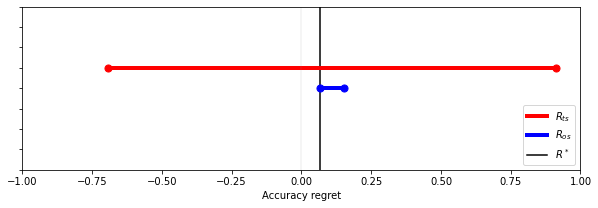

In [7]:

fig, ax = plt.subplots(figsize=(10,3))
R=oracle_regret(data, u, 'ACCURACY')

plt.plot([R_TS_down, R_TS_up], [0.05, 0.05], color='r', linestyle='-', label="$R_{ts}$",  linewidth=4)
plt.scatter(R_TS_down, 0.05,  color='r', s=50)
plt.scatter(R_TS_up, 0.05,  color='r', s=50)

plt.plot([R_OS_down, R_OS_up], [0, 0], color='b', linestyle='-', label="$R_{os}$",  linewidth=4)
plt.scatter(R_OS_down, 0,  color='b', s=50)
plt.scatter(R_OS_up, 0,  color='b', s=50)

plt.axvline(R, color='k', zorder=0, linestyle='-', label="$R^*$")

plt.axvline(color='grey', alpha=.1)
plt.ylim([-.2,.2])
plt.xlim([-1,1])
plt.legend(loc='lower right')
plt.xlabel("Accuracy regret")
plt.ylabel("")
ax.set(yticklabels=[]) 

plt.savefig('examples.pdf', dpi=600)

## MSM bounds

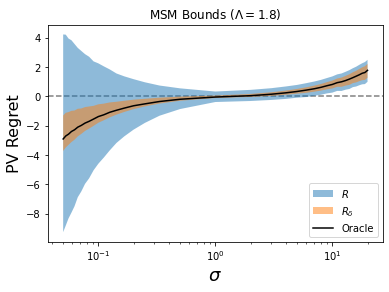

In [8]:
nz = 10
n_runs = 10
Lambda = 1.8
dgp = {
    'N': 15000,
    'nz': nz,
    'beta': 2.5*(1/nz) ,
    'wa': np.array([-1.6, .01, 2, .01]), 
    'wd': np.array([-1, 1.7, .01, 1.5, .2, .2]),
    'w_mu1': np.array([.12, .8, .02, .9, .3, .6]),
    'w_mu0': np.array([.33, .05, 1.8, .05, .2, .5]),
    'lambda': 1.8
}

results = []
id_strategies=['MSM']

results = pv_simulation(dgp, id_strategies, n_runs)
crdf = pd.concat(results)
crdf = crdf[crdf['tag'] == 'Population']
crdf = crdf.sort_values(by='cost_ratio')
crdf = crdf.groupby('cost_ratio').mean().reset_index()

plt.axhline(0, color='grey', zorder=1, linestyle='--')
plt.fill_between(crdf['cost_ratio'], crdf['TS_down'], crdf['TS_up'], alpha=.5, label='$R$')
plt.fill_between(crdf['cost_ratio'], crdf['OS_down'], crdf['OS_up'], alpha=.5, label='$R_{\delta}$')
plt.plot(crdf['cost_ratio'], crdf['R'], color='k', label='Oracle')
plt.xscale('log',base=10) 
plt.legend(loc='lower right')

plt.xlabel('$\sigma$', fontsize=18)
plt.ylabel('PV Regret', fontsize=16)
plt.title(f'MSM Bounds ($\Lambda={Lambda}$)')
plt.savefig('figs/msm_pv_regret.png', dpi=400, bbox_inches='tight')

## Iterate over different values of lambda

In [10]:
nz = 10
n_runs = 30

dgp = {
    'N': 15000,
    'nz': nz,
    'beta': 2.5*(1/nz) ,
    'wa': np.array([-1.6, .01, 2, .01]), 
    'wd': np.array([-1, 1.7, .01, 1.5, .2, .2]),
    'w_mu1': np.array([.12, .8, .02, .9, .3, .6]),
    'w_mu0': np.array([.33, .05, 1.8, .05, .2, .5]),
}

design_results = []
id_strategies=['MSM']
lambdas = np.arange(1, 4, .05)

# for lam in lambdas:

for lam in lambdas:
    dgp['lambda'] = lam
    design_results.extend(pv_simulation(dgp, id_strategies, n_runs))

crdf = pd.concat(design_results)
crdf = crdf[crdf['tag'] == 'Population']
crdf['TS_includes_zero'] = ((crdf['TS_down'] <= 0) & (crdf['TS_up'] >= 0)).astype(int)
crdf['OS_includes_zero'] = ((crdf['OS_down'] <= 0) & (crdf['OS_up'] >= 0)).astype(int)



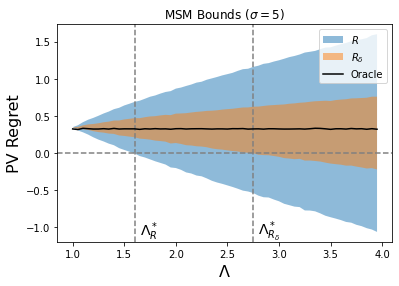

In [14]:
CR=5
crdf = pd.concat(design_results)
crdf = crdf[crdf['tag'] == 'Population']
crdf['TS_includes_zero'] = ((crdf['TS_down'] <= 0) & (crdf['TS_up'] >= 0)).astype(int)
crdf['OS_includes_zero'] = ((crdf['OS_down'] <= 0) & (crdf['OS_up'] >= 0)).astype(int)

sdf = crdf[(crdf['tag'] == 'Population') & (crdf['cost_ratio'] == CR)]
sdf = sdf.groupby(['cost_ratio', 'lambda']).mean().reset_index()
sdf['TS_includes_zero'] = ((sdf['TS_down'] <= 0) & (sdf['TS_up'] >= 0)).astype(int)
sdf['OS_includes_zero'] = ((sdf['OS_down'] <= 0) & (sdf['OS_up'] >= 0)).astype(int)
TS_lambda_star = sdf[sdf['TS_includes_zero'] == 1]['lambda'].min()
OS_lambda_star = sdf[sdf['OS_includes_zero'] == 1]['lambda'].min()

crdf = pd.concat(design_results)
crdf = crdf[(crdf['tag'] == 'Population') & (crdf['cost_ratio'] == CR)]

plt.text(TS_lambda_star+.05, -1.1, '$\Lambda^*_{R}$', fontsize=14)
plt.text(OS_lambda_star+.05, -1.1, '$\Lambda^*_{R_\delta}$', fontsize=14)

crdf = crdf.sort_values(by='lambda')
crdf = crdf.groupby('lambda').mean().reset_index()

plt.fill_between(crdf['lambda'], crdf['TS_down'], crdf['TS_up'], alpha=.5, label='$R$')
plt.fill_between(crdf['lambda'], crdf['OS_down'], crdf['OS_up'], alpha=.5, label='$R_{\delta}$')
plt.plot(crdf['lambda'], crdf['R'], color='k', label='Oracle')

plt.axhline(0, color='grey', zorder=1, linestyle='--')
plt.axvline(TS_lambda_star, color='grey', zorder=1, linestyle='--')
plt.axvline(OS_lambda_star, color='grey', zorder=1, linestyle='--')


plt.xlabel('$\Lambda$', fontsize=16)
plt.ylabel('PV Regret', fontsize=16)
plt.legend(loc='upper right')
plt.title(f'MSM Bounds ($\sigma=5$)')

plt.savefig('figs/pv_lambda_slider.png', dpi=400, bbox_inches='tight')

# Fix cost ratio, vary lambda, include virtical line for Lambda^*

## Design sensitivity plot

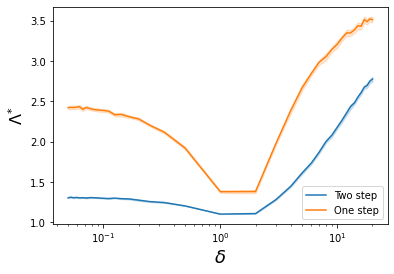

In [146]:
crdf = pd.concat(design_results)
crdf = crdf[crdf['tag'] == 'Population']
crdf['TS_includes_zero'] = ((crdf['TS_down'] <= 0) & (crdf['TS_up'] >= 0)).astype(int)
crdf['OS_includes_zero'] = ((crdf['OS_down'] <= 0) & (crdf['OS_up'] >= 0)).astype(int)

ls_results = []

for cr in crdf['cost_ratio'].unique():
    for run in crdf['run'].unique():
        crslice = crdf[(crdf['cost_ratio'] == cr) & (crdf['run'] == run)]
        ts_lambda_star = crslice[crslice['TS_includes_zero'] == 1]['lambda'].min()
        os_lambda_star = crslice[crslice['OS_includes_zero'] == 1]['lambda'].min()
    

        ls_results.append({
            'cr': cr,
            'Two step': ts_lambda_star,
            'One step': os_lambda_star,
            'run': run
        })
    lsdf = pd.DataFrame(ls_results)
    
lsdf = lsdf.sort_values(by='cr')
lsdf = lsdf.melt(id_vars=['cr', 'run'])

sns.lineplot(data=lsdf, x="cr", y="value", hue='variable')
plt.xlabel('$\delta$', fontsize=18)
plt.ylabel('$\Lambda^{*}$', fontsize=16)
plt.xscale('log',base=10) 
plt.legend(loc='lower right')

plt.savefig('figs/pv_lambds_delta_slider.png', dpi=400, bbox_inches='tight')

## Empirical demonstration with Obermeyer et al data

In [95]:
(data['risk_score_t'] > 5).astype(int).mean()

0.28672104766661116

In [85]:
data = pd.read_csv('data/obermeyer.csv')
data['D'] = pd.Categorical(data['program_enrolled_t'])
data['A'] = pd.Categorical((data['risk_score_t'] > 20).astype(int))
data['A'] = data['arrhythmia_elixhauser_tm1']

data['Y'] = (data['gagne_sum_t'] >= 2).astype(int)




In [78]:
data

,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,race,...,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t,D,A,Y
8,1.087141,0,1000.0,0.0,118.0,5.800000,39.1,0.490000,78.0,black,...,0,1,1,0,1,1,1,0,0,1
20,11.092237,0,2900.0,0.0,124.0,NaN,NaN,NaN,NaN,black,...,0,0,0,0,0,4,2,0,0,1
23,0.611517,0,1900.0,400.0,106.0,NaN,NaN,NaN,NaN,black,...,0,1,0,0,1,0,0,0,0,0
30,4.552404,0,1900.0,100.0,140.0,6.233333,40.8,1.000000,81.0,black,...,0,0,1,0,0,1,1,0,0,1
47,1.885510,0,2000.0,0.0,123.0,NaN,37.9,0.955000,NaN,black,...,0,0,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48719,12.807882,0,61400.0,44900.0,120.0,5.400000,37.9,0.838333,149.0,black,...,0,0,0,0,0,1,1,0,0,1
48721,7.525055,0,3700.0,0.0,117.0,5.900000,38.2,NaN,NaN,black,...,0,0,0,0,0,4,2,0,0,1
48748,7.694921,0,8300.0,2500.0,161.0,5.400000,35.0,0.770000,114.0,black,...,0,1,0,0,1,6,2,0,0,1
48749,0.000000,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,black,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data['old'] = 'dem_age_band_65-74_tm1', 'dem_age_band_75+_tm1'

In [118]:


data.groupby(['race','dem_age_band_75+_tm1']).mean()['program_enrolled_t']

race   dem_age_band_75+_tm1
black  0                       0.012717
       1                       0.033163
white  0                       0.007519
       1                       0.023378
Name: program_enrolled_t, dtype: float64

In [119]:
data = pd.read_csv('data/obermeyer.csv')
data['D'] = data['program_enrolled_t']
data['A'] = data['arrhythmia_elixhauser_tm1'].astype(int)
data['Y'] = (data['gagne_sum_t'] >= 1).astype(int)
# data = data[data['race'] == 'black']

dgp = {
    'lambda': 2,
    'N': 10000,
    'nz': 10,
    'beta': 2.5*(1/10) ,
    'wa': np.array([-1.95, .01, 2, .01]), 
    'wd': np.array([-1.1, 1.7, .01, 1.5, .2, .2]),
    'w_mu1': np.array([1.3, .8, .02, .9, .3, .6]),
    'w_mu0': np.array([1.5, .05, 1.8, .05, .2, .5])
}
u = np.array([[0,0], [0, 0]])
id_strategies = ['MSM']
metric='TPR'

metrics = ['FPR', 'FNR', 'TPR', 'TNR', 'ACCURACY', 'PPV', 'NPV']

for metric in metrics:
    bounds = compare_bounds(data, dgp, '', 1, u, metric, id_strategies, run=0)
    print(metric)
    print(f"TS: [{bounds[0]['TS_down']:.2}, {bounds[0]['TS_up']:.2}]")
    print(f"OS: [{bounds[0]['OS_down']:.2}, {bounds[0]['OS_up']:.2}]")
    
    print(f"Regret: {bounds[0]['R']}")

FPR
TS: [-0.031, 0.33]
OS: [0.017, 0.3]
Regret: 0.014857503039034714
FNR
TS: [-0.66, -0.059]
OS: [-0.64, -0.1]
Regret: -0.13987882437060162
TPR
TS: [0.059, 0.66]
OS: [0.1, 0.64]
Regret: 0.13987882437060176
TNR
TS: [-0.33, 0.031]
OS: [-0.3, -0.017]
Regret: -0.014857503039034659
ACCURACY
TS: [0.024, 0.18]
OS: [0.036, 0.17]
Regret: 0.06942850114791732
PPV
TS: [-0.45, 0.98]
OS: [-0.45, 0.98]
Regret: -0.041507749017972606
NPV
TS: [-0.014, 0.013]
OS: [-0.0016, 0.0012]
Regret: 0.03451420522186821
